In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker

from scipy.sparse import bsr_array

from scipy.optimize import curve_fit

import scipy.constants as const

In [2]:
plt.rcParams['figure.figsize'] = [4, 3]

# Doppler effect explained
First let's explain the doppler effect. I will jump out the high school physics but offer an intuitive explanation on how to derive and understand the equation.

the doppler effect equation is given as follows:
$$f'=\left(\frac{c\pm v_r}{c\pm v_s}\right)f_0$$

here $v_r$ is the receiver's velocity relative to the <b>medium</b>.(notice here it is the medium!! not the receiver.) the sign is plus when the receiver's velocity tends to increase the distance beween the receiver and source. Vice versa.
$v_s$ is the source's velocity relative to the <b>medium</b>.(notice here again it is the medium!!!!) the sign is plus if the source's velocity tends to increase the distance between the receiver and source.

the sign is actually intuitive to understand, but it's tricky why the source's velocity is in the bottom and the receiver's velocity is in the top. 

One intuitive method to understand this is to calculate the disturbation the receiver is receiving in a period of time, which can be described as $N=\frac{c\Delta t}{\lambda}$. here $c\Delta t$ is the wave's speed in the medium. (remember it is the wave's speed in the medium!!! and this number won't change unless the medium is changed!! which is impossible in our senario.) $\lambda$ is the distance of the disturbations, notice here it is the distance between the disturbations, not the wavelength!!(later will show that this distance does not necessarily equal to the wavelength). then keep in mind that $f\lambda_0=c$.

Now the trick is that, when source moving towards the receiver, the distance of the distrubations changes!! you modify the $\lambda$ in the bottom!!! While when receiver moving towards the source, the number of disturbations increases(becomes $N=\frac{c\Delta t+v_r\Delta t}{\lambda}$). 
this should help you instantly derive which is on the top and which is in the bottom.

now plug in the numbers, in our ion doppler, 
$$\Delta \lambda = \frac{v}{c}\lambda_0$$

or

$$\lambda'=\frac{c-v}{c}\lambda_0$$

For our Doppler tomography system, in the velocity space, it can be written as following

$$\lambda'=\frac{c-(v_x, v_y)\cdot \vec{v}}{c}\lambda_0$$

here $\vec{v}$ is the unit vector along the detection direction, should be obvious why doing so.


In [3]:
## physics constants
c = const.c # speed of light
lamda0 = 480.60202 # FOR our doppler system, we use the 480.60202nm line
Ar_mass = 39.948 # this data is refferred to the nist periodical table
mp= const.proton_mass # the mass of the proton, also refferred to the nist periodical table
kb = const.k # Boltzmann constant
ev = const.electron_volt # one electron volt in joules 

## data extraction parameters
horizontal_span = 100 # the pixels to extract on the ICCD
linear_dispersion = 0.004179537 # the linear dispersion, average value 

resolution = 18

## Let's see our ion velocity distribution!!
Since in order to do an inversion, you have to prepare the velocity space mesh in advance. Let see how ArII ion's velocity distributes in our TS-6 device!! 

One dimensional Maxwellian distribution is given by
$$f(u)=A\exp\left(-\frac{1}{2}mu^2/KT\right)$$
where K is Boltzmann's constant, u is the velocity. interesting point to notice here is <b>that $\frac{1}{2}mu^2$ is the kinetic energy!!!</b>
The constant A is related to the density n
$$A=n\left(\frac{m}{2\pi KT}\right)^{1/2}$$
In plasma research $KT$, which is the mean kinetic energy of the particles, is often given in $eV$, for example $KT=T_i=1eV, 2eV, 3eV...$ 

In this case, when plugging the numbers into the equation, <b>remember to multiply $T_i$ by $eV=1.6\times10^{-19}J$ to make sure that the unit is Joule... otherwise terrible things happen!!!!</b>

Notice here that $m$ is the particle mass given in [kg], which is $m=m_p\times M=1.672621924\times 10^{-27}M$

In [4]:
def maxwellian_dis(Ti, u, m=Ar_mass):
    '''
    this function calculates the maxwellian distribution,
    note Ti here is give in eV, and m is given in kg
    '''
    return (m/(2 * np.pi * Ti * ev)) ** (0.5) * np.exp(-0.5 * m * u **2 / (Ti * ev))

In [5]:
Ti = 50
u = np.linspace(-1.1e5, 1.1e5, 3000)

fu = maxwellian_dis(Ti, u, Ar_mass*mp)

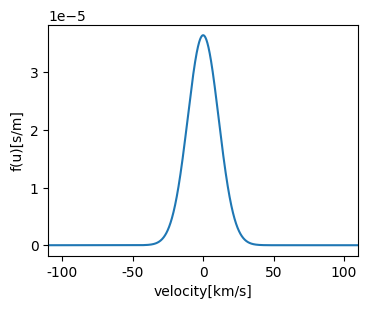

In [6]:
plt.plot(u, fu)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%.0f' %(x/1000)))

plt.xlabel('velocity[km/s]')
plt.ylabel('f(u)[s/m]')

plt.margins(x=0)

In [7]:
np.sqrt(Ar_mass * mp / 2 / np.pi / 10 /ev) # the estimated value for A

8.147066890175125e-05

In [9]:
np.sqrt(10 * ev / Ar_mass /mp) # the estimated value for sigma

4896.759604153161

# Once the velocity distribution is obtained...
use Gaussian fitting to recover the std of the velocity distribution.

$$G(u)=A\exp\bigg[-\frac{1}{2}\big(\frac{u-u_0}{\sigma}\big)^2\bigg]$$

Then the FWHM can be given as 

$$\Delta u_{\frac{1}{2}}=2\sigma\sqrt{2\ln2}$$

Finally use the following equation to recover the temperature!
$$T_i[ev]=\frac{m\Delta u_{\frac{1}{2}}}{(2\sqrt{2\ln2})^2}$$
once again!! <b>do not forget to devide the value by $eV=1.6\times10^{-9}$!!!! because the right hand side's unit is joule, and you want your temperature unit to be $eV$</b>

In [10]:
def Gaussian(u, A, u0, s):
    return  A* np.exp(-0.5 * ((u - u0) / s) ** 2)

In [11]:
[A_op, u0_op, s_op], pov = curve_fit(Gaussian, u, fu,p0=[1e-5, 0, 3e4])

In [12]:
u12 = 2 * s_op * np.sqrt(2 * np.log(2))

In [13]:
Ar_mass * mp * (u12) **2 / (8 * np.log(2)) / ev

50.00000000044598

# Projection matrix
We recover our spectrum back into velocity distribution using algebraic reconstruction technique. And in the algebraic reconstruction, the most difficult thing is to find the projection matrix...

The First step is to generate a mesh, on which you want to recover the velocity distribution. As seen above, our maximum velocity at temperature 10eV is around 100km/s. 

Also as seen above, the wavelength drift is given as 

$$\lambda'=\frac{c-\Arrowvert(v_x, v_y)\cdot \vec{v}\Arrowvert}{c}\lambda_0$$

But one problem is that ICCD camera is also discrete, sometimes the photon emitted by one point in our mesh may not be perfectly the wavelength our ICCD's pixel is recording. So, some response function is needed. 

Here I will assume that when one photon hits the ICCD, its energy is fully recorded by the nearest pixel.

## Let's begin with the dopple drift

In [13]:
vx = np.linspace(-1e5, 1e5, resolution)
vy = np.linspace(-1e5, 1e5, resolution)

Vx, Vy = np.meshgrid(vx, vy)

In [14]:
vx_vy = np.vstack((Vx.ravel(), Vy.ravel())) # this is the coordinates of all points

In [15]:
v_0 = np.array([[1, 0]]) # the unit vector along 0 degree and 30 degree
v_30 = np.array([[np.sqrt(3), 1]]) / 2
v_m30 = np.array([[-np.sqrt(3), 1]]) / 2 # the unit vector along -30 degree

In [16]:
projection_0 = v_0 @ vx_vy # this line calculates the velocity along the 30 degree of each point
projection_30 = v_30 @ vx_vy
projection_m30 = v_m30 @ vx_vy

In [17]:
delta_lamda_0 = projection_0 / c * lamda0
delta_lamda_30 = projection_30 / c * lamda0
delta_lamda_m30 = projection_m30 / c * lamda0

lamda_p_0 = lamda0 - delta_lamda_0
lamda_p_30 = lamda0 - delta_lamda_30
lamda_p_m30 = lamda0 - delta_lamda_m30

## Okay! Now let's work on the projection matrix!

In [18]:
wavelength = lamda0 + np.arange(-horizontal_span//2, horizontal_span//2) * linear_dispersion

In [19]:
print('the minimum and maximum drifted wavelength along 0 degree: (%fnm, %fnm)' 
      %(lamda_p_0.min(), lamda_p_0.max()))
print('the minimum and maximum drifted wavelength along 30 degree: (%fnm, %fnm)' 
      %(lamda_p_30.min(), lamda_p_30.max()))
print('the minimum and maximum wavelength on our extracted pixels: (%fnm, %fnm)' 
      %(wavelength.min(), wavelength.max()))

the minimum and maximum drifted wavelength along 0 degree: (480.441708nm, 480.762332nm)
the minimum and maximum drifted wavelength along 30 degree: (480.383030nm, 480.821010nm)
the minimum and maximum wavelength on our extracted pixels: (480.393043nm, 480.806817nm)


As a conclusion our extracted pixels has reasonably covered our range

In [20]:
P_0_idx = np.abs((lamda_p_0 - wavelength[:, None])).argmin(axis=0)
P_30_idx = np.abs((lamda_p_30 - wavelength[:, None])).argmin(axis=0) + horizontal_span
P_m30_idx = np.abs((lamda_p_m30 - wavelength[:, None])).argmin(axis=0) + horizontal_span * 2

In [21]:
P_idx = np.concatenate([P_0_idx, P_30_idx, P_m30_idx])

In [22]:
column_idx = np.tile(np.arange(0, resolution**2), 3)

In [23]:
P = bsr_array((np.ones(3 * resolution ** 2), (P_idx, column_idx)), shape=(horizontal_span*3, resolution**2))

# Start loading the real experimental data!!!

In [24]:
file = glob.glob('./240619/shot10-Ar-width 4us-gain 3800-dealy 464us.sif/formatted_data/Group3*csv')

In [25]:
file

['./240619/shot10-Ar-width 4us-gain 3800-dealy 464us.sif/formatted_data/Group3_5-30.csv',
 './240619/shot10-Ar-width 4us-gain 3800-dealy 464us.sif/formatted_data/Group3_12-30.csv',
 './240619/shot10-Ar-width 4us-gain 3800-dealy 464us.sif/formatted_data/Group3_5-0.csv',
 './240619/shot10-Ar-width 4us-gain 3800-dealy 464us.sif/formatted_data/Group3_12-0.csv']

In [26]:
df1 = pd.read_csv(file[0])
df2 = pd.read_csv(file[1])
df3 = pd.read_csv(file[2])
df4 = pd.read_csv(file[3])

In [27]:
A = np.zeros(horizontal_span * 3)

In [28]:
I1 = np.array(df1['intensity'])
I2 = np.array(df2['intensity'])
I3 = np.array(df3['intensity'])
I4 = np.array(df4['intensity'])

In [35]:
A[:horizontal_span] = I3 - I3[:10].mean()
A[horizontal_span:2*horizontal_span] = I1 - I1[:10].mean()
A[2*horizontal_span:horizontal_span*3] = I2 - I2[:10].mean()

In [37]:
x, res, rank, s = np.linalg.lstsq(P.toarray(), A)

/tmp/ipykernel_371/1827400661.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, res, rank, s = np.linalg.lstsq(P.toarray(), A)


In [38]:
%matplotlib widget

In [39]:
plt.imshow(x.reshape(resolution, resolution))